<a href="https://colab.research.google.com/github/damessina/PyMC3_budget_allocation_framework/blob/main/PyMC3_Budget_Allocation_Framework_For_Online_Advertising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## This is a framework designed for the budget allocation across one or multiple campaigns with the objective of maximizing marginality

#### The data used is from the Google Merchandise Store

In [ ]:
## Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.neighbors import LocalOutlierFactor as lof
from sklearn.preprocessing import StandardScaler
import pymc3 as pm
import arviz as az
from scipy.optimize import fsolve
from sympy import *
from matplotlib.dates import DateFormatter
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
url = '/content/drive/MyDrive/Dati/Data_Analytics.csv'
df = pd.read_csv(url)

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y%m%d')

In [ ]:
df.head(5)

,Date,Cost,Transactions
0,2021-12-08,12.51,48
1,2022-03-07,7.51,34
2,2022-02-27,17.75,30
3,2022-02-25,6.93,29
4,2022-03-10,41.77,25


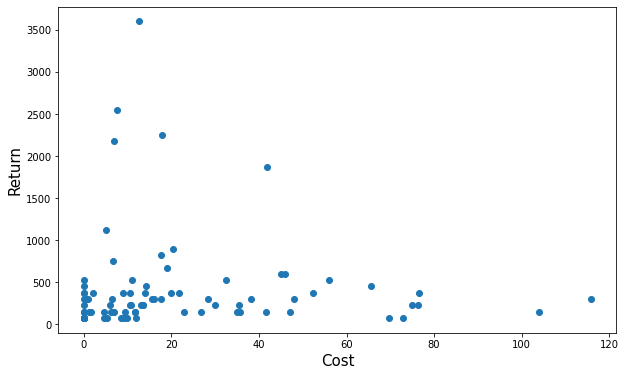

In [ ]:
cost = df['Cost'].values
conversion = df['Transactions'].values*75

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(cost, conversion)
ax.set_xlabel("Cost", fontsize=15)
ax.set_ylabel("Return", fontsize = 15)

fig.show()

#### Scale the data and use the LOF algorithm for outlier detection

In [ ]:
attributes = ['Cost', 'Transactions']

X = df[attributes].values

scaler = StandardScaler()

data = scaler.fit_transform(X)

Text(0, 0.5, 'N of outliers')

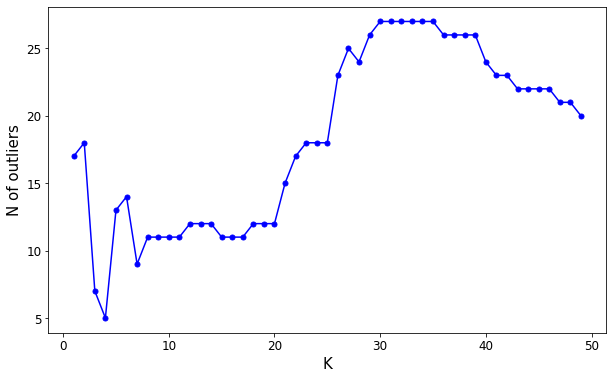

In [ ]:
## Let's see how the outlier number changes over the number of neighbors

outliers_num = []
for i in range(1,50):
  clf =lof(n_neighbors=i)
  outliers = clf.fit_predict(data)
  outliers_num.append(np.count_nonzero(outliers == -1))

plt.figure(figsize=(10,6))
plt.plot(range(1,50),outliers_num,color='blue', marker='o',markerfacecolor='Blue', markersize=5)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.xlabel('K', fontsize=15)
plt.ylabel('N of outliers', fontsize=15)

In [ ]:
clf = lof(n_neighbors= 10)
outliers = clf.fit_predict(data)

df['outliers'] = outliers
print(df['outliers'].value_counts())

df_clean= df[df['outliers']==1]
df_clean.reset_index(drop=True, inplace = True)
df_clean.drop(columns=['outliers'], inplace=True)

 1    73
-1    11
Name: outliers, dtype: int64


/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:4913: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


#### Dataset after the cleaning

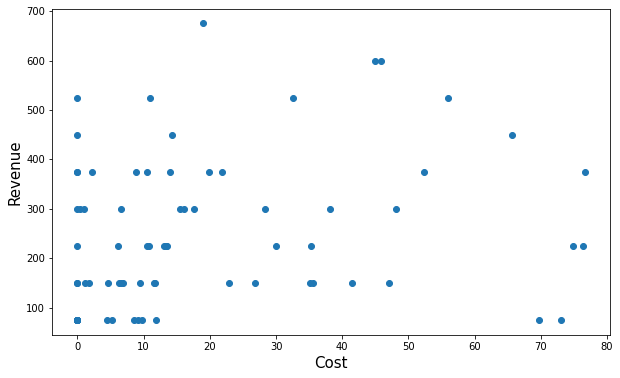

In [ ]:
cost = df_clean['Cost'].values
conversion = df_clean['Transactions'].values*75

fig, ax = plt.subplots(figsize=(10, 6))

ax.scatter(cost, conversion)
ax.set_xlabel("Cost", fontsize=15)
ax.set_ylabel("Revenue", fontsize=15)

fig.show()

#### Define the model and sampling process

In [ ]:
# Design the model for the parameter inference
with pm.Model() as model:

    alpha = pm.Beta('alpha', alpha= 2, beta= 2) # prior probability of alpha parameter
    epsilon = pm.HalfNormal('epsilon', sigma= 10) # prior probability of error
    lam = pm.HalfNormal('lam', sigma= 20) # prior probability of lambda parameter 
    link = pm.Deterministic('link',  lam*cost**alpha) 

    likelihood = pm.Normal('conversions', mu=link, sd=epsilon, observed=conversion)

In [ ]:
with model:
  trace = pm.sample(10000, chains = 2, cores = 2, tune=5000, target_accept= 0.90, return_inferencedata=True)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [lam, epsilon, alpha]


Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 88 seconds.


#### Plot the results: posterior sampled probability and random walk

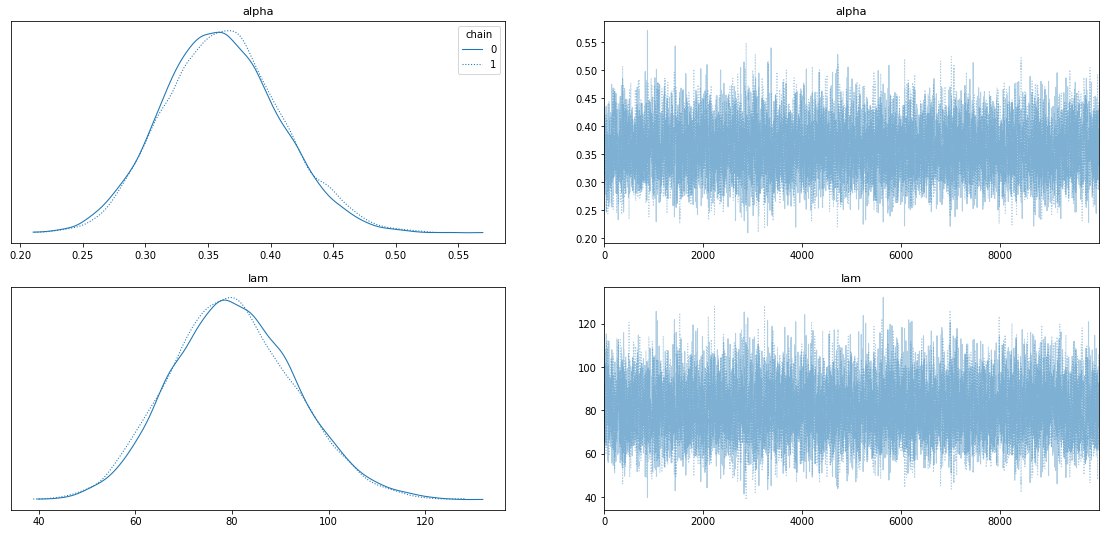

In [ ]:
fig = pm.plot_trace(trace, var_names=['alpha', 'lam'], figsize=(19.5, 9), kind='trace', legend=True)

#### Plot the Highest Density Interval

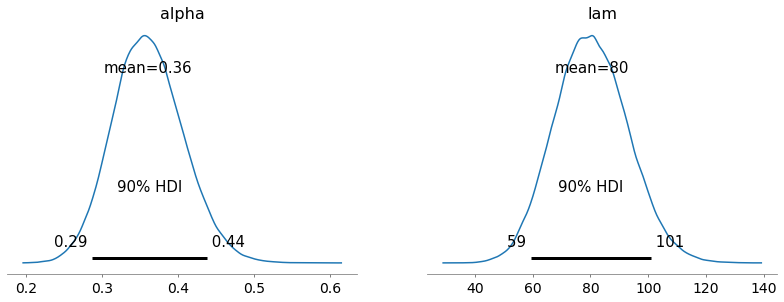

In [ ]:
fig = az.plot_posterior(trace, var_names=['alpha', 'lam'], hdi_prob = 0.90)

#### Let's plot the joint posterior probability to see the relationships between parameters

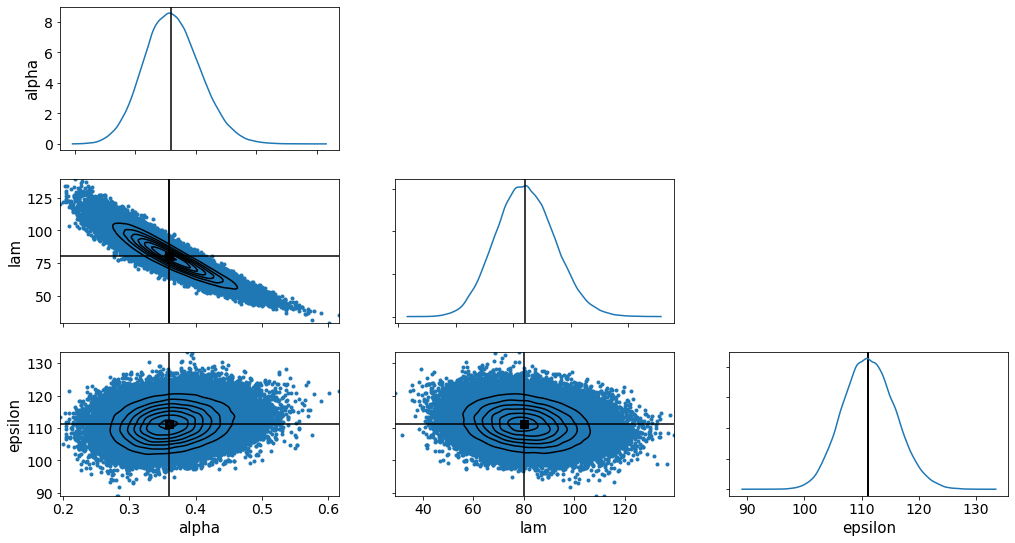

In [ ]:
## Plot the sampling distribution for every pair of variables
ax = az.plot_pair(trace, var_names=["alpha", "lam", 'epsilon'], kind=["scatter", "kde"], kde_kwargs={"fill_last": False}, marginals=True, point_estimate="median", figsize=(17, 9))
plt.show()

#### Plot the density in a colored manner

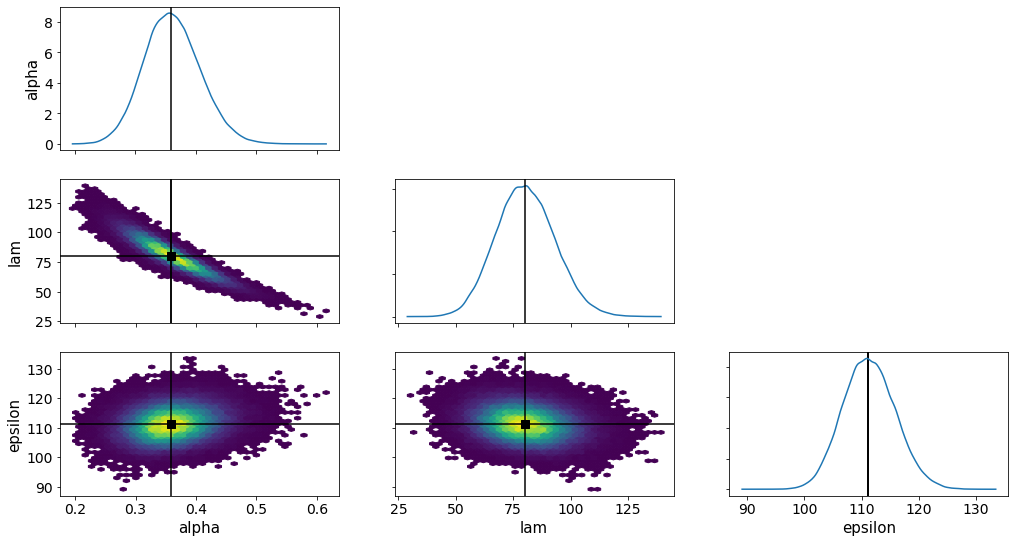

In [ ]:
## Plot the sampling distribution for every pair of variables
ax = az.plot_pair(trace, var_names=["alpha", "lam", 'epsilon'], kind=["hexbin"], marginals=True, point_estimate="median", figsize=(17, 9))
plt.show()

/usr/local/lib/python3.7/dist-packages/arviz/plots/jointplot.py:145: UserWarning: plot_joint will be deprecated. Please use plot_pair instead.
  warnings.warn("plot_joint will be deprecated. Please use plot_pair instead.")


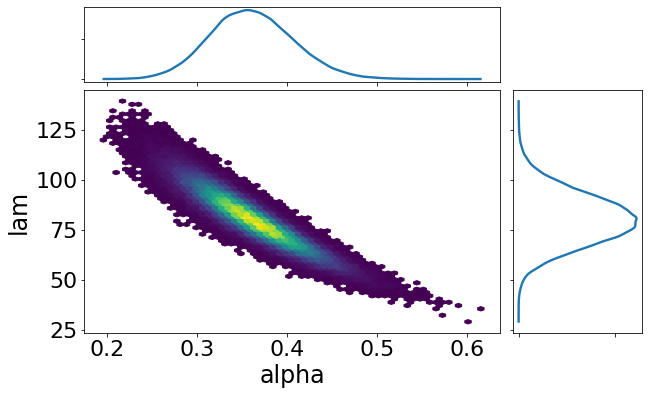

In [ ]:
fig = az.plot_joint(trace, kind='hexbin', figsize=(10, 6), var_names=['alpha', 'lam'])

#### Predict some curves in order to see how the predictions behave wrt the actual data

/usr/local/lib/python3.7/dist-packages/pymc3/sampling.py:1690: UserWarning: samples parameter is smaller than nchains times ndraws, some draws and/or chains may not be represented in the returned posterior predictive sample
  "samples parameter is smaller than nchains times ndraws, some draws "


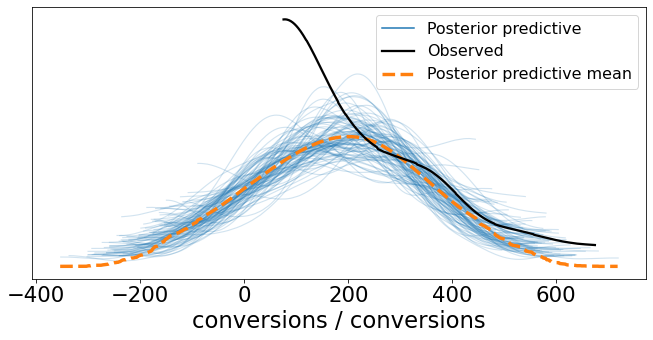

In [ ]:
with model:
    ppc = pm.sample_posterior_predictive(
        trace, 100, model
    )

    fig = az.plot_ppc(az.from_pymc3(posterior_predictive=ppc, model=model), figsize=(11, 5))

#### Plot 300 curves wrt the data without boundaries

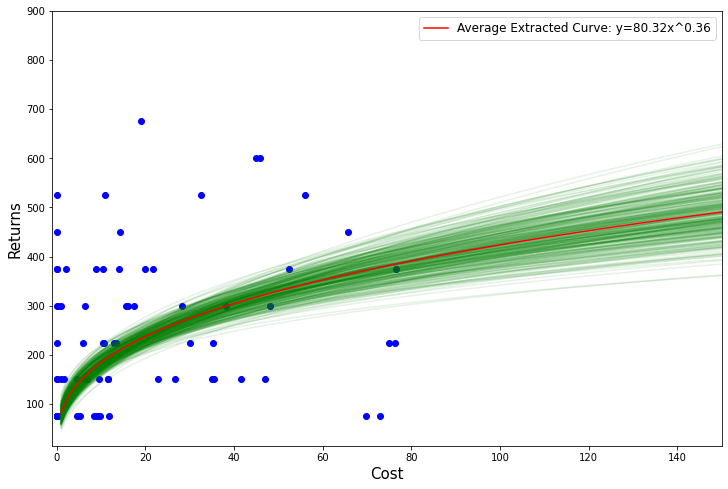

In [ ]:
## Plot the possible payout curves extracted by our model
fig, ax = plt.subplots(figsize=(12,8))
c = int(random.choice(trace.posterior.chain))
for i in range(300):
  d = int(random.choice(trace.posterior.draw))
  sample = trace.posterior.sel(chain=c, draw=d)
  lam = float(sample.lam)
  exp = float(sample.alpha)
  vector = np.linspace(1, 1000, 1000)
  conversions = lam*vector**exp
  ax.plot(vector.reshape(-1,1), conversions.reshape(-1,1), markersize= 1.5, color='green', alpha=0.1)
ax.scatter(cost, conversion, color='blue')
conversions_ad_mean=float(np.mean(trace.posterior.lam[c]))*vector**float(np.mean(trace.posterior.alpha[c]))
ax.plot(vector.reshape(-1,1), conversions_ad_mean.reshape(-1,1), markersize = 3.5,  color='red', label='Average Extracted Curve: y={0}x^{1}'.format(round(float(np.mean(trace.posterior.lam[c])), 2), round(float(np.mean(trace.posterior.alpha[c])), 2)))
ax.set_ylabel("Returns", fontsize=15)
ax.set_xlabel("Cost", fontsize=15)
ax.set_xlim([-1, 150])
ax.set_ylim([15, 900])
ax.legend(loc="best", fontsize=12)
fig.show()

#### Plot the summary results of the sampling process and then plot the autocorrelation plot to see if the sampling process worked badly

In [ ]:
summary = az.summary(trace, var_names=['alpha', 'lam'], kind='all')
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.361,0.046,0.274,0.448,0.000,0.000,40737.0,45242.0,1.0
lam,80.409,12.724,56.916,104.481,0.062,0.044,41654.0,44817.0,1.0


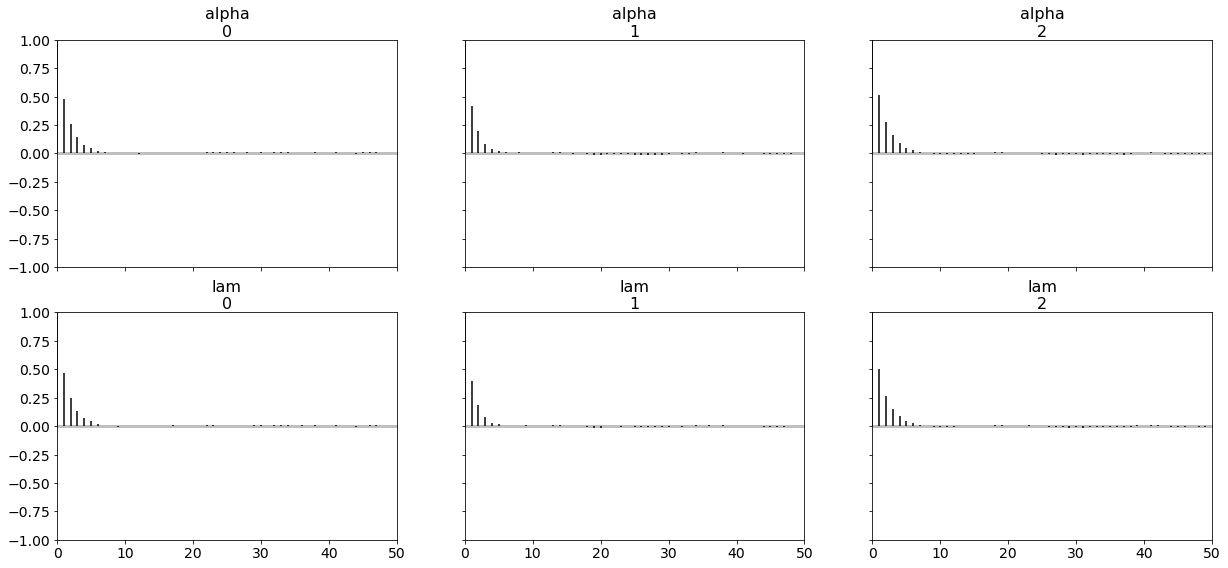

In [ ]:
autocorr = az.plot_autocorr(trace, var_names=['alpha', 'lam'], max_lag=50)

#### Find the optimal point with the marginalistic approach and with the average conversion value approach

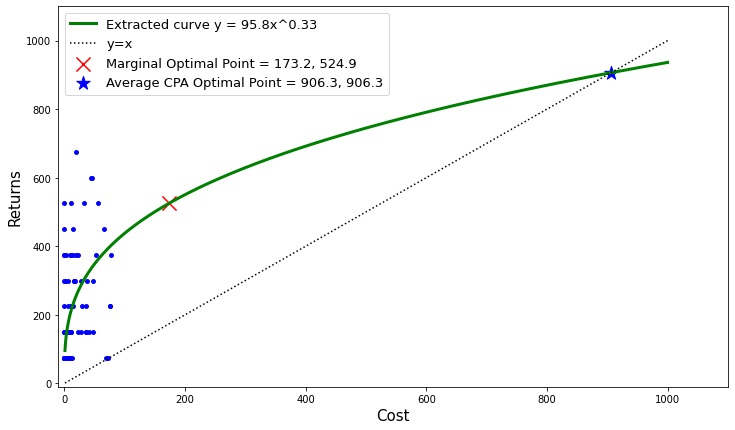

In [ ]:
def solver(z):
  vector = z[0]
  conversions = z[1]
  f = np.empty(2)

  f[0] = vector-conversions
  f[1] = lam*vector**exp-conversions

  return f

vector = np.linspace(1, 1000, 1000)
c = int(random.choice(trace.posterior.chain))
d = int(random.choice(trace.posterior.draw))
sample = trace.posterior.sel(chain=c, draw=d)
lam = np.round(float(sample.lam), 1)
exp = np.round(float(sample.alpha), 2)

fig, ax = plt.subplots(figsize=(12, 7))

conversions = lam*vector**exp
ax.plot(vector.reshape(-1,1), conversions.reshape(-1,1), linewidth= 3, color='green', label="Extracted curve y = {}x^{}".format(lam, exp))
x = Symbol('x')
y = lam*x**exp
yprime = y.diff(x)
x = solve(yprime-1)
x_1 = float(x[0])
ax.scatter(x_1, lam*x_1**exp, label=r'Marginal Optimal Point = {}, {}'.format(np.round(x_1, 1), np.round(lam*x_1**exp, 1)), s=200, color='red', marker='x')
ax.scatter(cost, conversion, color='blue', s=15)

z_guess = np.array([2000, 2000])
z = fsolve(solver, z_guess)

ax.plot(vector, vector, label=r'y=x', color = 'black', linestyle='dotted')
ax.scatter(z[0], z[1], label=r'Average CPA Optimal Point = {}, {}'.format(np.round(z[0], 1), np.round(z[1], 1)), s=200, color='blue', marker='*')

plt.xlabel('Cost', fontsize=15)
plt.ylabel('Returns', fontsize=15)
ax.set_xlim([-10, 1100])
ax.set_ylim([-10, 1100])
plt.legend(loc='best', fontsize=13)
plt.show()